# Mini Project 3
# Milling Machine Failure Prediction

This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

1. UID: unique identifier ranging from 1 to 10000
2. product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
3. type: just the product type L, M or H from column 2
4. air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
5. process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
6. rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
7. torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
8. tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
9. a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

1. tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
2. heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
3. power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
4. overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
5. random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.
This dataset is part of the following publication, please cite when using this dataset:
S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef


from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#import pandas_profiling

#Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [48]:
df = pd.read_csv('ai4i2020.csv')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [4]:
df.describe(include='all').T

count unique     top  freq       mean         std  \
UDI                      10000.0    NaN     NaN   NaN     5000.5  2886.89568   
Product ID                 10000  10000  M14860     1        NaN         NaN   
Type                       10000      3       L  6000        NaN         NaN   
Air temperature [K]      10000.0    NaN     NaN   NaN  300.00493    2.000259   
Process temperature [K]  10000.0    NaN     NaN   NaN  310.00556    1.483734   
Rotational speed [rpm]   10000.0    NaN     NaN   NaN  1538.7761  179.284096   
Torque [Nm]              10000.0    NaN     NaN   NaN   39.98691    9.968934   
Tool wear [min]          10000.0    NaN     NaN   NaN    107.951   63.654147   
Machine failure          10000.0    NaN     NaN   NaN     0.0339    0.180981   
TWF                      10000.0    NaN     NaN   NaN     0.0046    0.067671   
HDF                      10000.0    NaN     NaN   NaN     0.0115    0.106625   
PWF                      10000.0    NaN     NaN   NaN     0.0095    0.097009   
OSF                      10000.0    NaN     NaN   NaN     0.0098    0.098514   
RNF                      10000.0    NaN     NaN   NaN     0.0019     0.04355   

                            min      25%     50%      75%      max  
UDI                         1.0  2500.75  5000.5  7500.25  10000.0  
Product ID                  NaN      NaN     NaN      NaN      NaN  
Type                        NaN      NaN     NaN      NaN      NaN  
Air temperature [K]       295.3    298.3   300.1    301.5    304.5  
Process temperature [K]   305.7    308.8   310.1    311.1    313.8  
Rotational speed [rpm]   1168.0   1423.0  1503.0   1612.0   2886.0  
Torque [Nm]                 3.8     33.2    40.1     46.8     76.6  
Tool wear [min]             0.0     53.0   108.0    162.0    253.0  
Machine failure             0.0      0.0     0.0      0.0      1.0  
TWF                         0.0      0.0     0.0      0.0      1.0  
HDF                         0.0      0.0     0.0      0.0      1.0  
PWF                         0.0      0.0     0.0      0.0      1.0  
OSF                         0.0      0.0     0.0      0.0      1.0  
RNF                         0.0      0.0     0.0      0.0      1.0

## Check for missing values

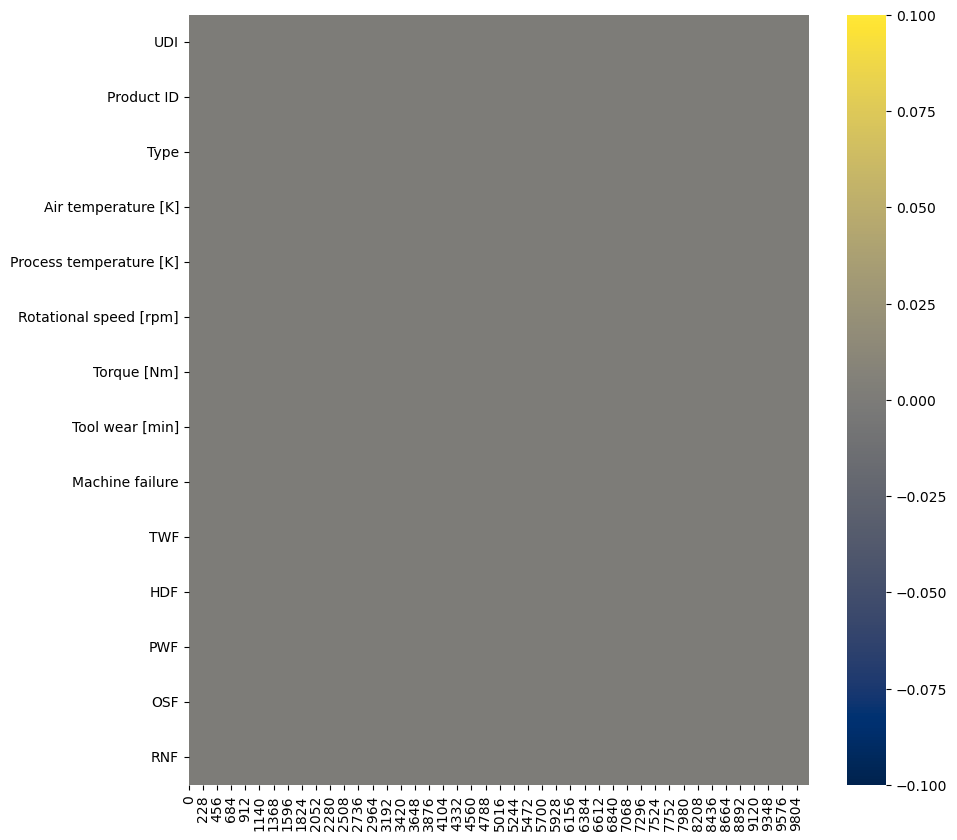

In [7]:
plt.figure(figsize=(10,10))
plot_kws={"s": 1}
sns.heatmap(df.isna().transpose(),
            cmap='cividis',
            linewidths=0.0,
           ).set_facecolor('white')

## Using Profiling Tool

In [50]:
from pandas_profiling import ProfileReport

# No missing values
# L model makes up 60% of total count.
# No duplicate



In [51]:
%%time
profile = ProfileReport(df,
                        title="Predictive Maintenance",
                        dataset={"description": "This profiling report was generated for Chirs Peng",
                                 "copyright_holder": "Chris Peng",
                                 "copyright_year": "2023",
                                },
                        explorative=True,
                       )
profile

CPU times: total: 15.6 ms
Wall time: 25.2 ms


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Drop columns with no predictive value

In [5]:
df.drop(['UDI','Product ID'],axis=1,inplace=True)

In [6]:
df.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  
0         42.8                0                0    0    0    0    0    0  
1         46.3                3                0    0    0    0    0    0  
2         49.4                5                0    0    0    0    0    0  
3         39.5                7                0    0    0    0    0    0  
4         40.0                9                0    0    0    0    0    0

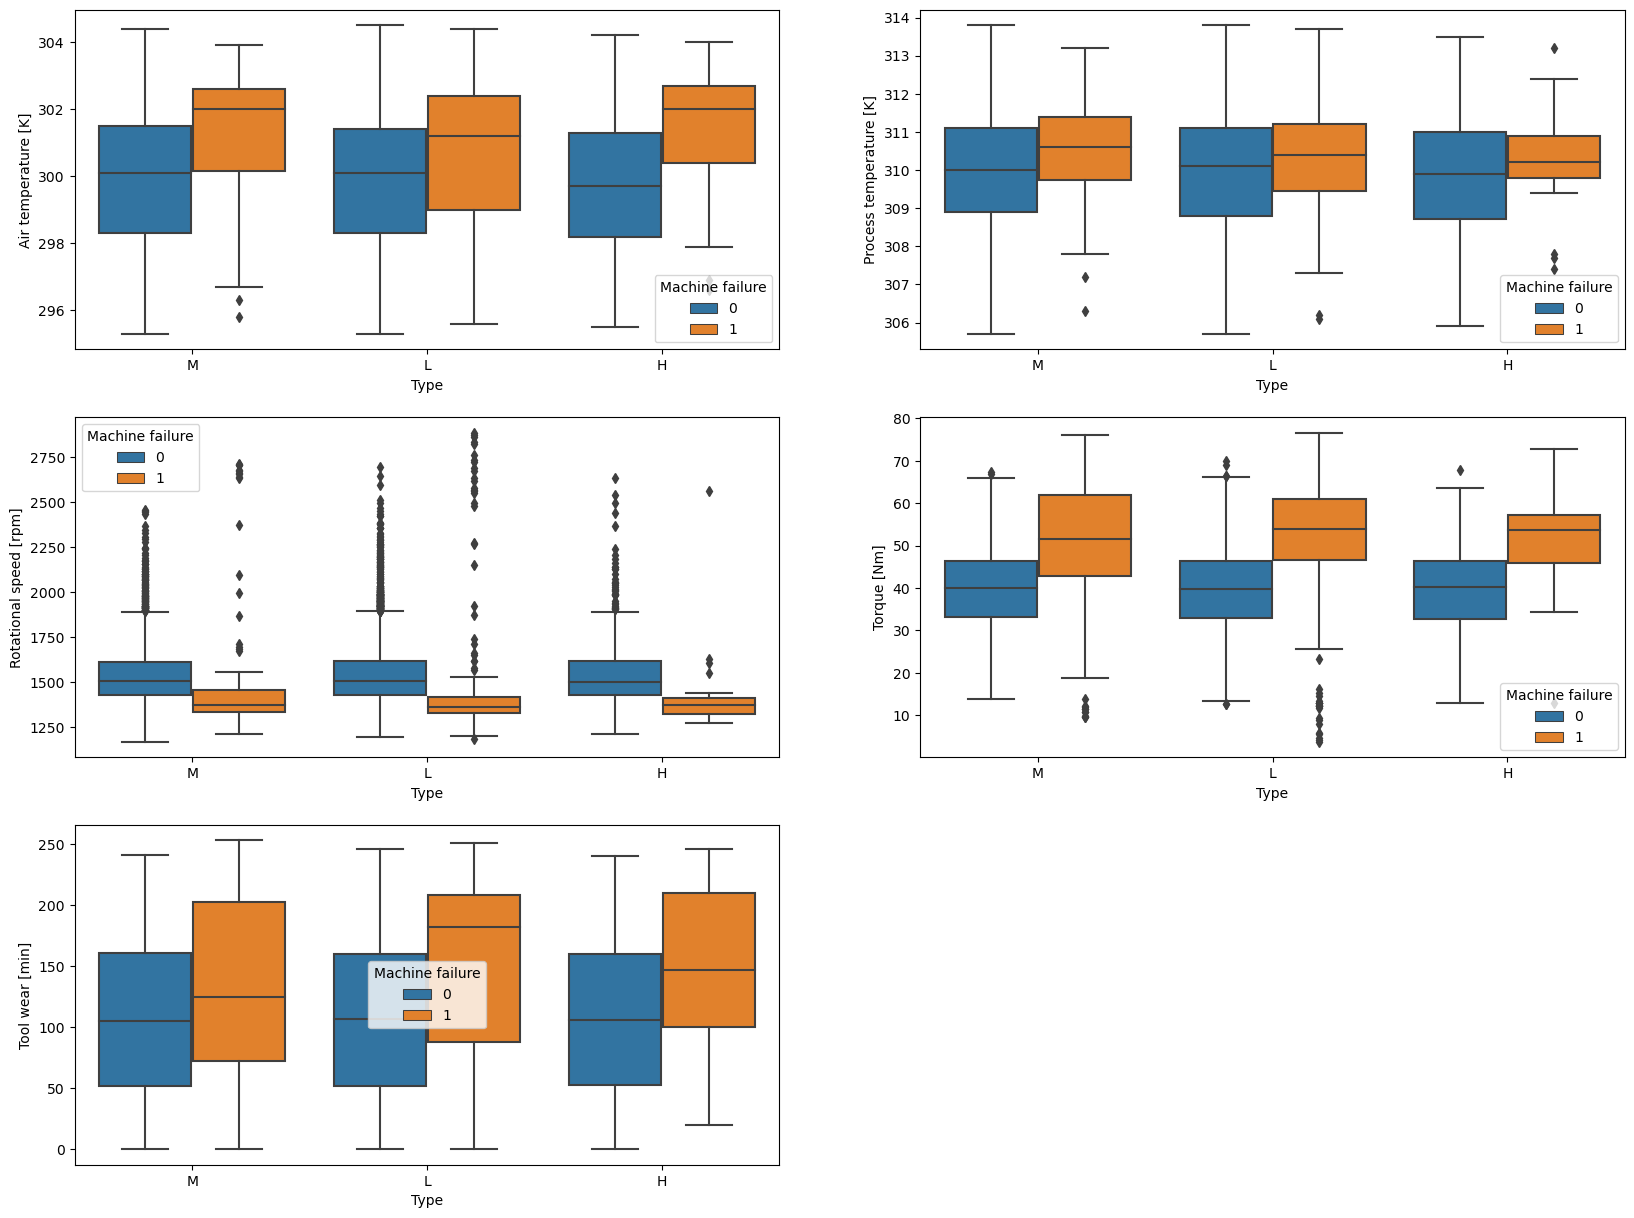

In [18]:
plt.figure(figsize = (20,15))
m=1
for i in ['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'] :
    plt.subplot(3,2,m)
    sns.boxplot(data=df,y=i,x="Type",hue="Machine failure")
    m+=1

In [33]:

df2=df[df['Machine failure']==1]
df2

Type  Air temperature [K]  Process temperature [K]  \
50      L                298.9                    309.1   
69      L                298.9                    309.0   
77      L                298.8                    308.9   
160     L                298.4                    308.2   
161     L                298.3                    308.1   
...   ...                  ...                      ...   
9758    L                298.6                    309.8   
9764    L                298.5                    309.5   
9822    L                298.5                    309.4   
9830    L                298.3                    309.3   
9974    L                298.6                    308.2   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
50                      2861          4.6              143                1   
69                      1410         65.7              191                1   
77                      1455         41.3              208                1   
160                     1282         60.7              216                1   
161                     1412         52.3              218                1   
...                      ...          ...              ...              ...   
9758                    2271         16.2              218                1   
9764                    1294         66.7               12                1   
9822                    1360         60.9              187                1   
9830                    1337         56.1              206                1   
9974                    1361         68.2              172                1   

      TWF  HDF  PWF  OSF  RNF  
50      0    0    1    0    0  
69      0    0    1    1    0  
77      1    0    0    0    0  
160     0    0    0    1    0  
161     0    0    0    1    0  
...   ...  ...  ...  ...  ...  
9758    1    0    0    0    0  
9764    0    0    1    0    0  
9822    0    0    0    1    0  
9830    0    0    0    1    0  
9974    0    0    1    1    0  

[339 rows x 12 columns]

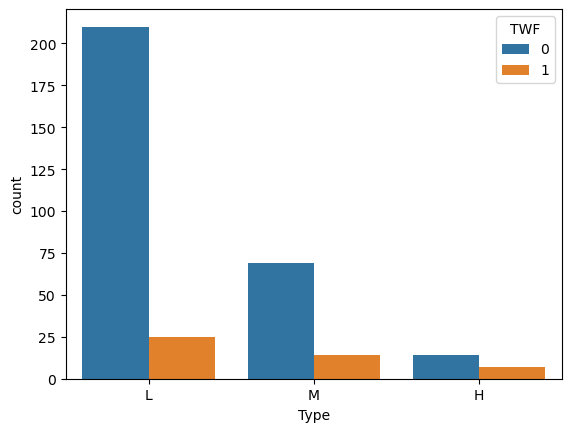

In [35]:
ax = sns.countplot(x="Type", hue=("TWF"), data=df2)

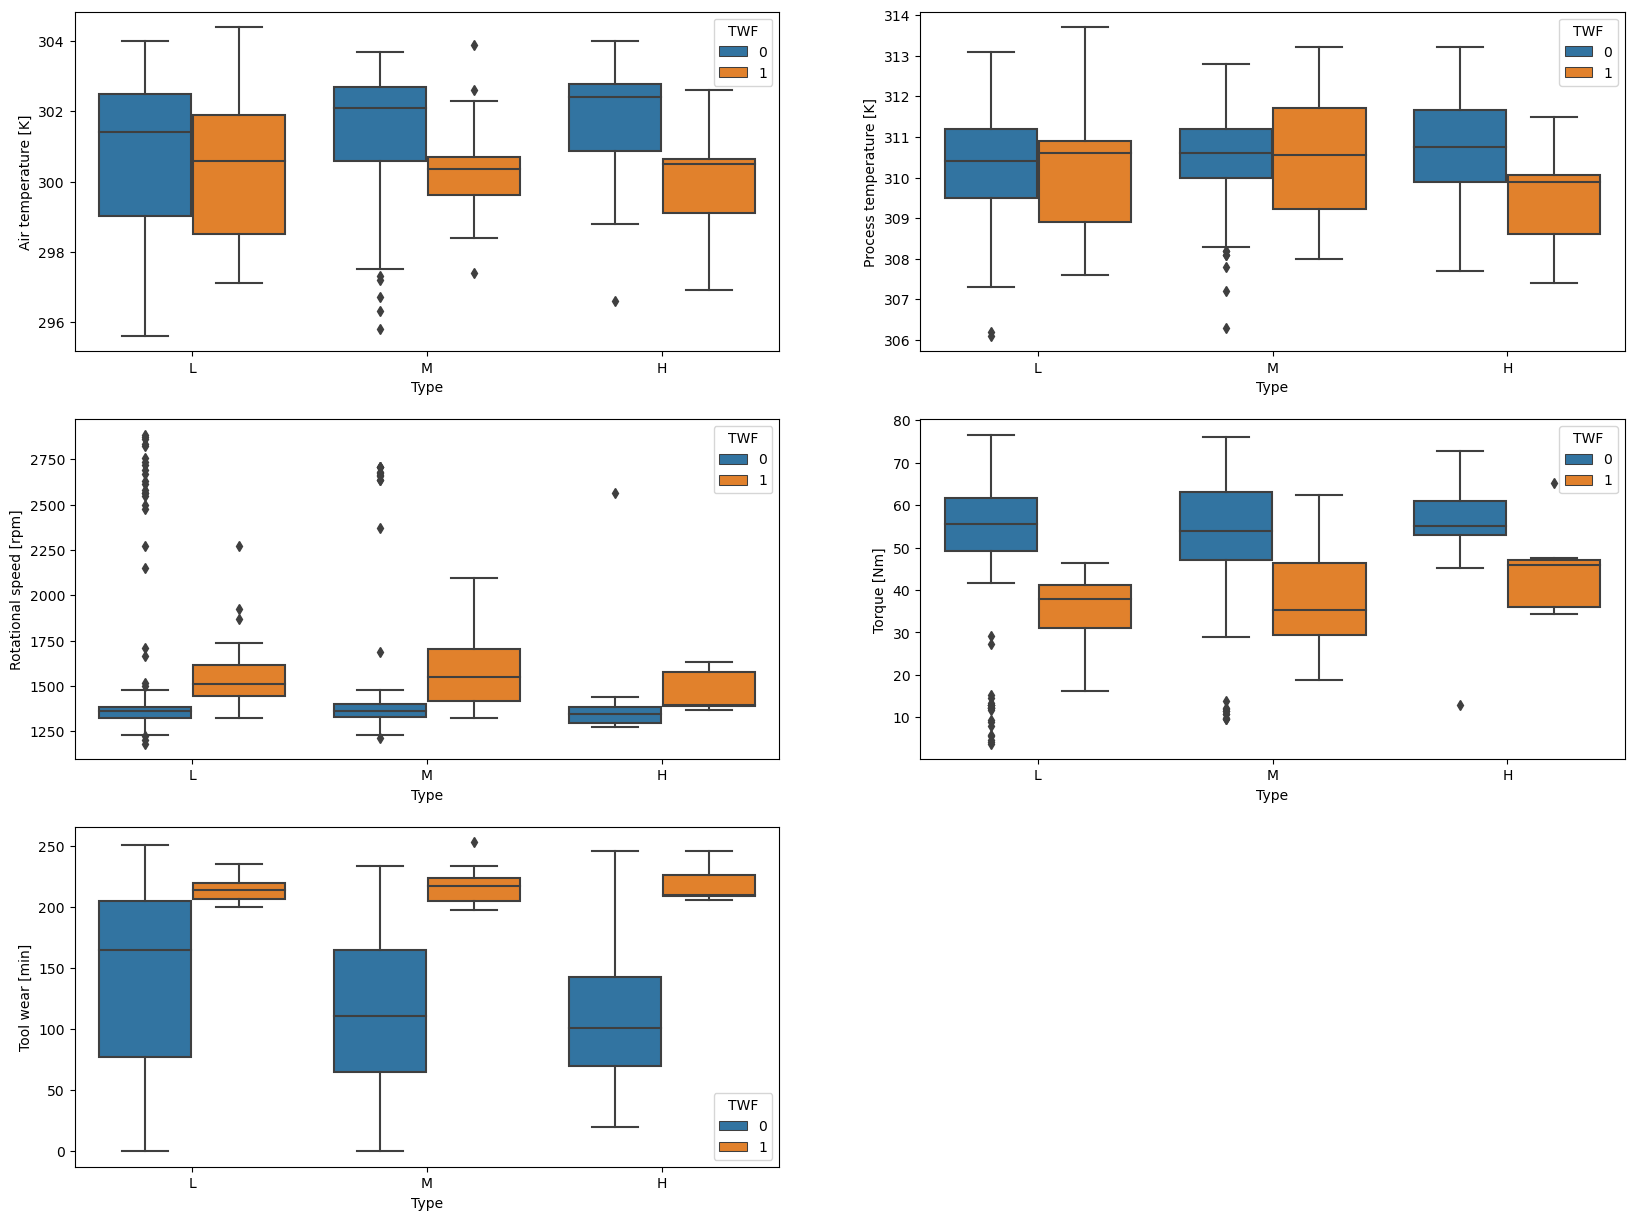

In [36]:
# Tool Wear Failure
# Postive corelated to rotational speed and tool wear
# They failed at very similar range of 

plt.figure(figsize = (20,15))
m=1
for i in ['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'] :
    plt.subplot(3,2,m)
    sns.boxplot(data=df2,y=i,x="Type",hue="TWF")
    m+=1

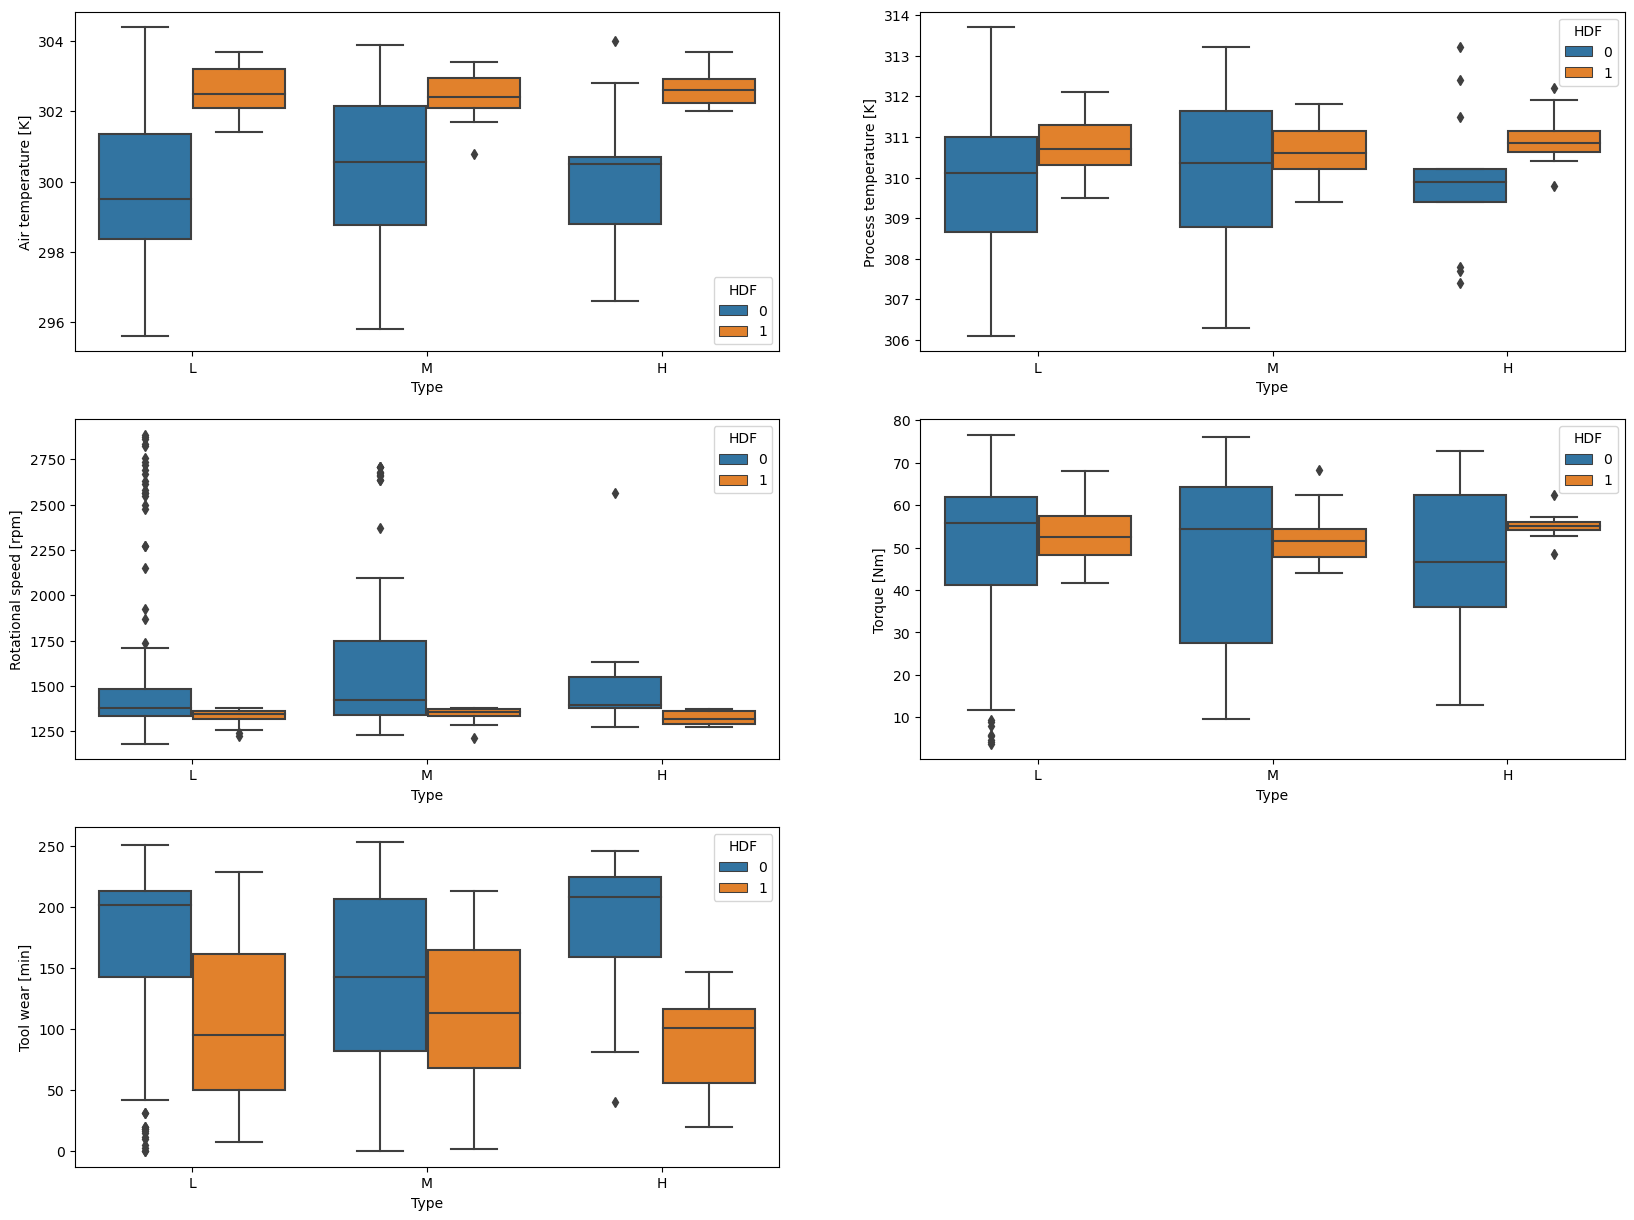

In [37]:
#Heat Dissipation Failure
#Positive corelated with air and process temperature
#All 3 models failed at similar mdeian for air and process temperature



plt.figure(figsize = (20,15))
m=1
for i in ['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'] :
    plt.subplot(3,2,m)
    sns.boxplot(data=df2,y=i,x="Type",hue="HDF")
    m+=1

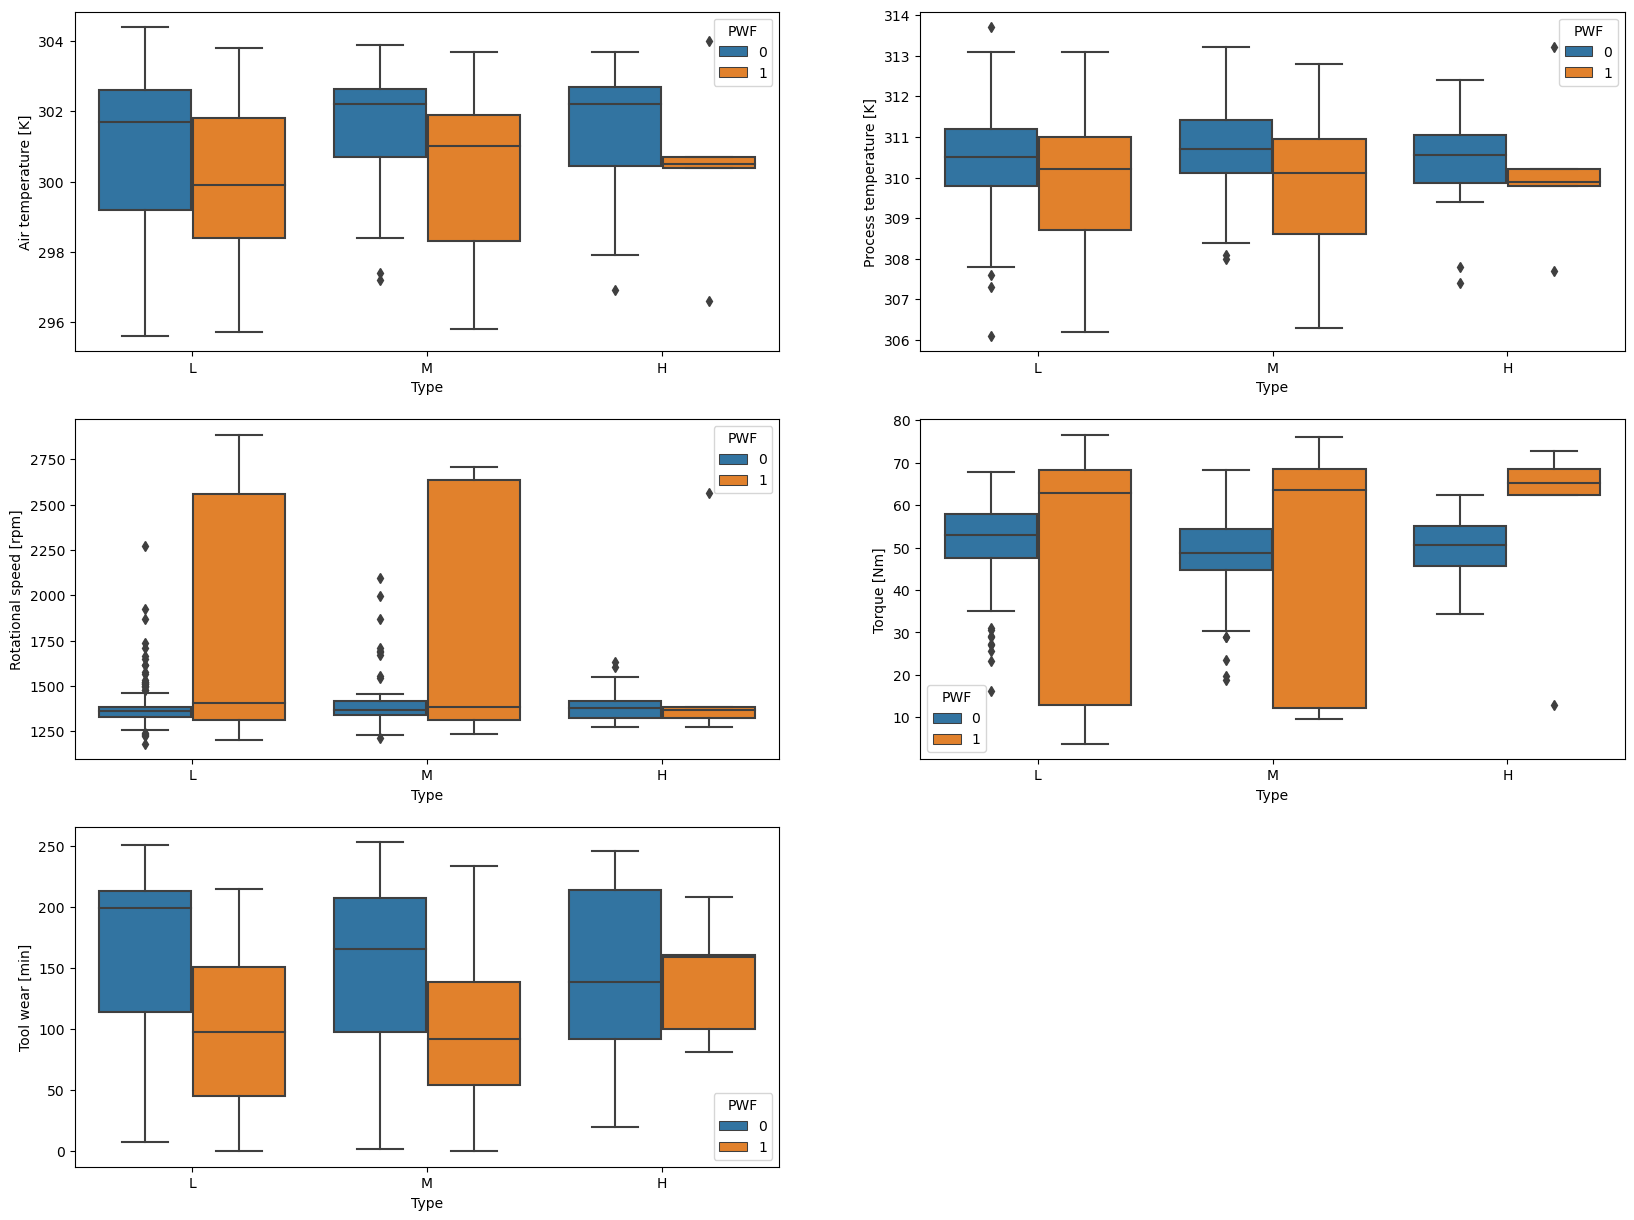

In [38]:
#Power Failure
#Positively corelated to Torque
#Noted that Model L and M breaks at IQR range of Torque compared to model H 


plt.figure(figsize = (20,15))
m=1
for i in ['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'] :
    plt.subplot(3,2,m)
    sns.boxplot(data=df2,y=i,x="Type",hue="PWF")
    m+=1

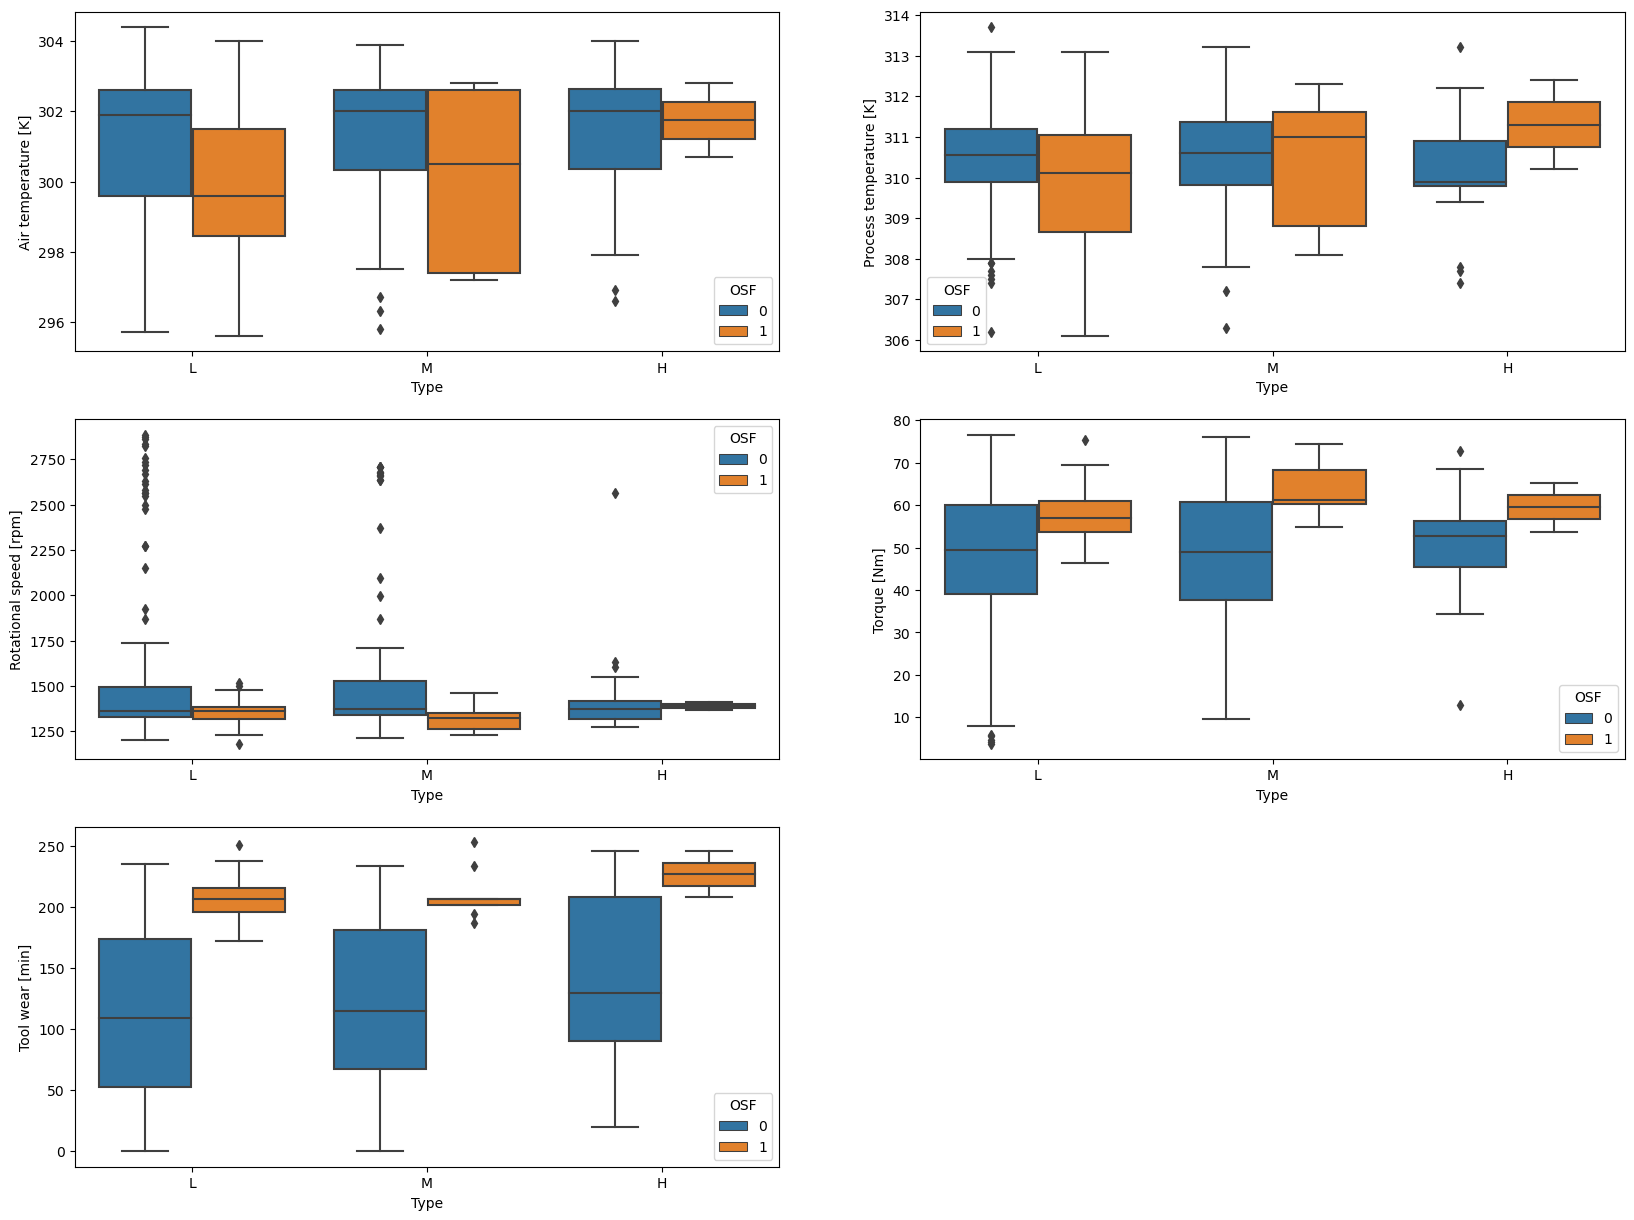

In [39]:
#Overstrain Failure
#Positive related to tool wear and torque
#Model L failed at the lowest median torque value


plt.figure(figsize = (20,15))
m=1
for i in ['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'] :
    plt.subplot(3,2,m)
    sns.boxplot(data=df2,y=i,x="Type",hue="OSF")
    m+=1

## Random failure cannot be predicted

In [7]:
df.drop(['RNF'],axis=1,inplace=True)

0    9885
1     115
Name: HDF, dtype: int64

## Incorporate into 1 column for multiclass prediction

In [8]:
df['Machine failure']=0
df['Machine failure'][df['TWF']==1]=1
df['Machine failure'][df['HDF']==1]=2
df['Machine failure'][df['PWF']==1]=3
df['Machine failure'][df['OSF']==1]=4
df.drop(['TWF','HDF','PWF','OSF'],axis=1,inplace=True)

C:\Users\chris\AppData\Local\Temp\ipykernel_40188\2368134999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Machine failure'][df['TWF']==1]=1
C:\Users\chris\AppData\Local\Temp\ipykernel_40188\2368134999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Machine failure'][df['HDF']==1]=2
C:\Users\chris\AppData\Local\Temp\ipykernel_40188\2368134999.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Machine failure'][df

In [9]:
# checking correct impute
df['Machine failure'].value_counts()

0    9670
2     106
4      98
3      83
1      43
Name: Machine failure, dtype: int64

In [10]:
df.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  
0         42.8                0                0  
1         46.3                3                0  
2         49.4                5                0  
3         39.5                7                0  
4         40.0                9                0

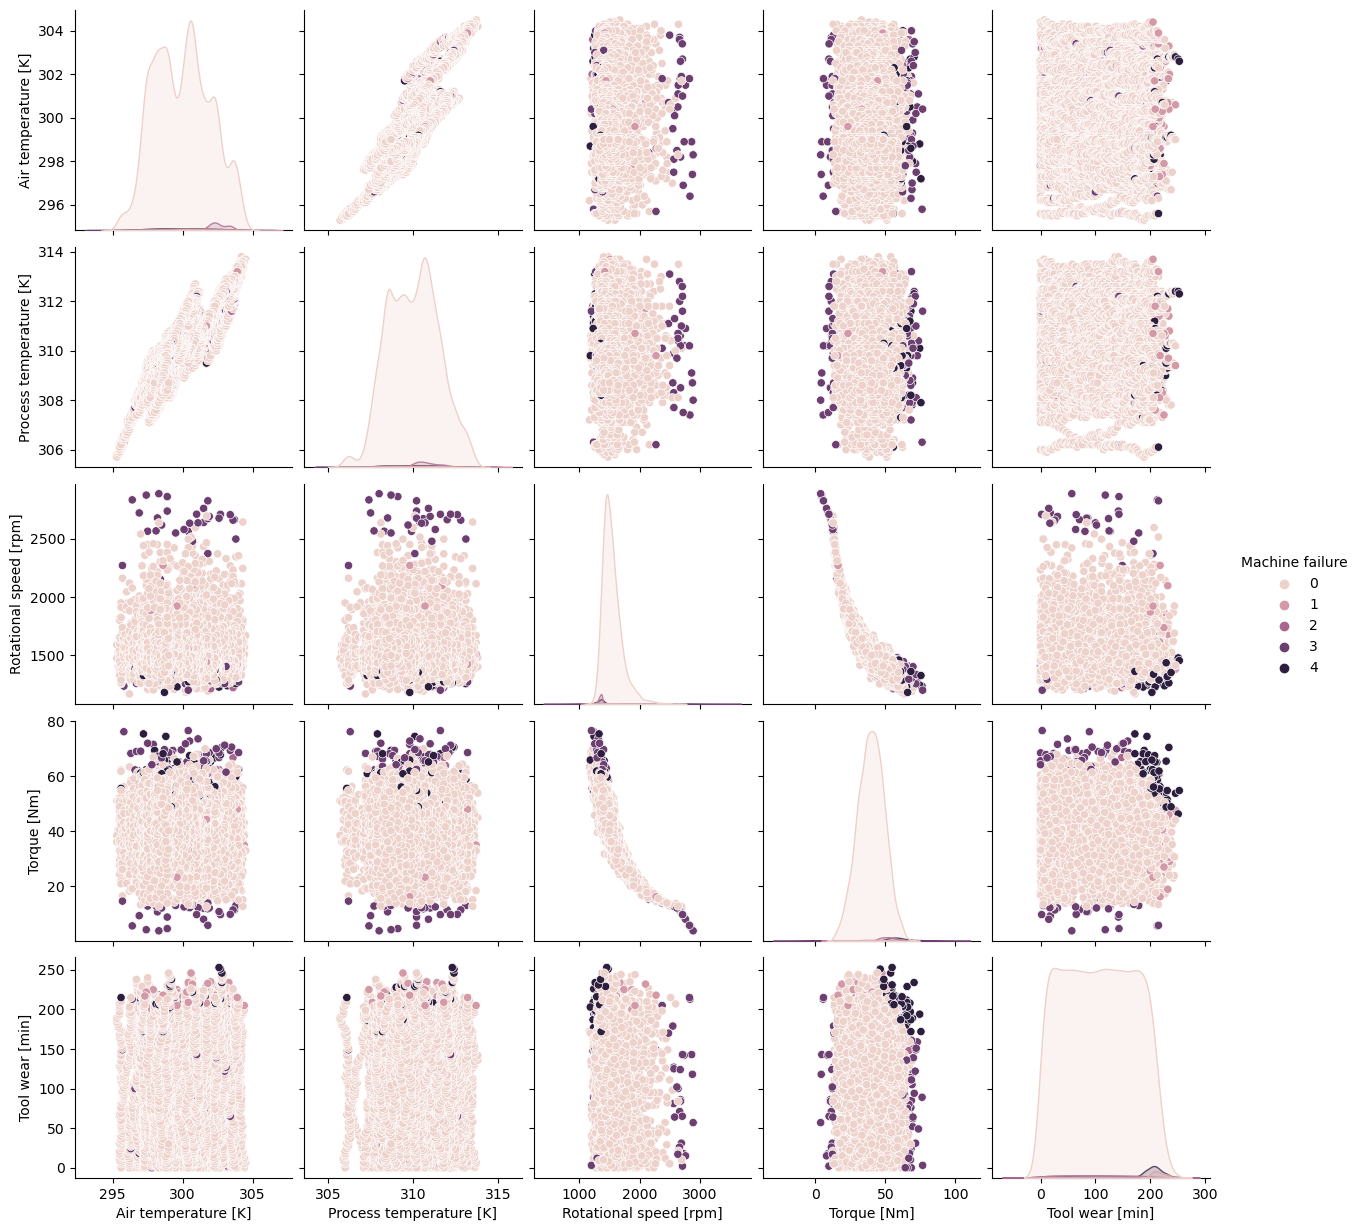

In [50]:
p=sns.pairplot(df, hue = 'Machine failure')

## Feature Engineering

Created 4 new features
 - 1. Power (P = τ x ω x 2 p / 60 000 ) (Kw)
 - 2. Temperature difference (K)
 - 3. TDP( Temperature Diff / Power) (K/Kw)
 - 4. TTW( Toruqe x Tool wear) (Nmmin)

In [11]:

df['Power_Kw']=df['Rotational speed [rpm]']*df['Torque [Nm]']*(22/7)/(60000)

df['Temp_diff_K'] = df['Process temperature [K]']-df['Air temperature [K]']

df['TDP_K/KW'] = df['Temp_diff_K']/df['Power_Kw']

df['TTW_Nmmin']=df['Torque [Nm]']*df['Tool wear [min]']


In [12]:
df.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  Power_Kw  Temp_diff_K  \
0         42.8                0                0  3.477194         10.5   
1         46.3                3                0  3.414735         10.5   
2         49.4                5                0  3.876253         10.4   
3         39.5                7                0  2.964945         10.4   
4         40.0                9                0  2.950095         10.5   

   TDP_K/KW  TTW_Nmmin  
0  3.019676        0.0  
1  3.074909      138.9  
2  2.683003      247.0  
3  3.507653      276.5  
4  3.559207      360.0

In [13]:
df.columns = df.columns.str.replace(" ", "_")
df.head()

Type  Air_temperature_[K]  Process_temperature_[K]  Rotational_speed_[rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque_[Nm]  Tool_wear_[min]  Machine_failure  Power_Kw  Temp_diff_K  \
0         42.8                0                0  3.477194         10.5   
1         46.3                3                0  3.414735         10.5   
2         49.4                5                0  3.876253         10.4   
3         39.5                7                0  2.964945         10.4   
4         40.0                9                0  2.950095         10.5   

   TDP_K/KW  TTW_Nmmin  
0  3.019676        0.0  
1  3.074909      138.9  
2  2.683003      247.0  
3  3.507653      276.5  
4  3.559207      360.0

In [14]:
df.isna().sum()

Type                       0
Air_temperature_[K]        0
Process_temperature_[K]    0
Rotational_speed_[rpm]     0
Torque_[Nm]                0
Tool_wear_[min]            0
Machine_failure            0
Power_Kw                   0
Temp_diff_K                0
TDP_K/KW                   0
TTW_Nmmin                  0
dtype: int64

In [18]:
df.describe().T

count         mean          std          min  \
Air_temperature_[K]      10000.0   300.004930     2.000259   295.300000   
Process_temperature_[K]  10000.0   310.005560     1.483734   305.700000   
Rotational_speed_[rpm]   10000.0  1538.776100   179.284096  1168.000000   
Torque_[Nm]              10000.0    39.986910     9.968934     3.800000   
Tool_wear_[min]          10000.0   107.951000    63.654147     0.000000   
Machine_failure          10000.0     0.089600     0.519807     0.000000   
Power_Kw                 10000.0     3.141136     0.533924     0.574451   
Temp_diff_K              10000.0    10.000630     1.001094     7.600000   
TDP_K/KW                 10000.0     3.286306     0.733225     1.633097   
TTW_Nmmin                10000.0  4314.664550  2826.567692     0.000000   

                                 25%          50%          75%           max  
Air_temperature_[K]       298.300000   300.100000   301.500000    304.500000  
Process_temperature_[K]   308.800000   310.100000   311.100000    313.800000  
Rotational_speed_[rpm]   1423.000000  1503.000000  1612.000000   2886.000000  
Torque_[Nm]                33.200000    40.100000    46.800000     76.600000  
Tool_wear_[min]            53.000000   108.000000   162.000000    253.000000  
Machine_failure             0.000000     0.000000     0.000000      4.000000  
Power_Kw                    2.781711     3.136776     3.502911      5.237069  
Temp_diff_K                 9.300000     9.800000    11.000000     12.100000  
TDP_K/KW                    2.794129     3.187916     3.667984     17.871829  
TTW_Nmmin                1963.650000  4012.950000  6279.000000  16497.000000

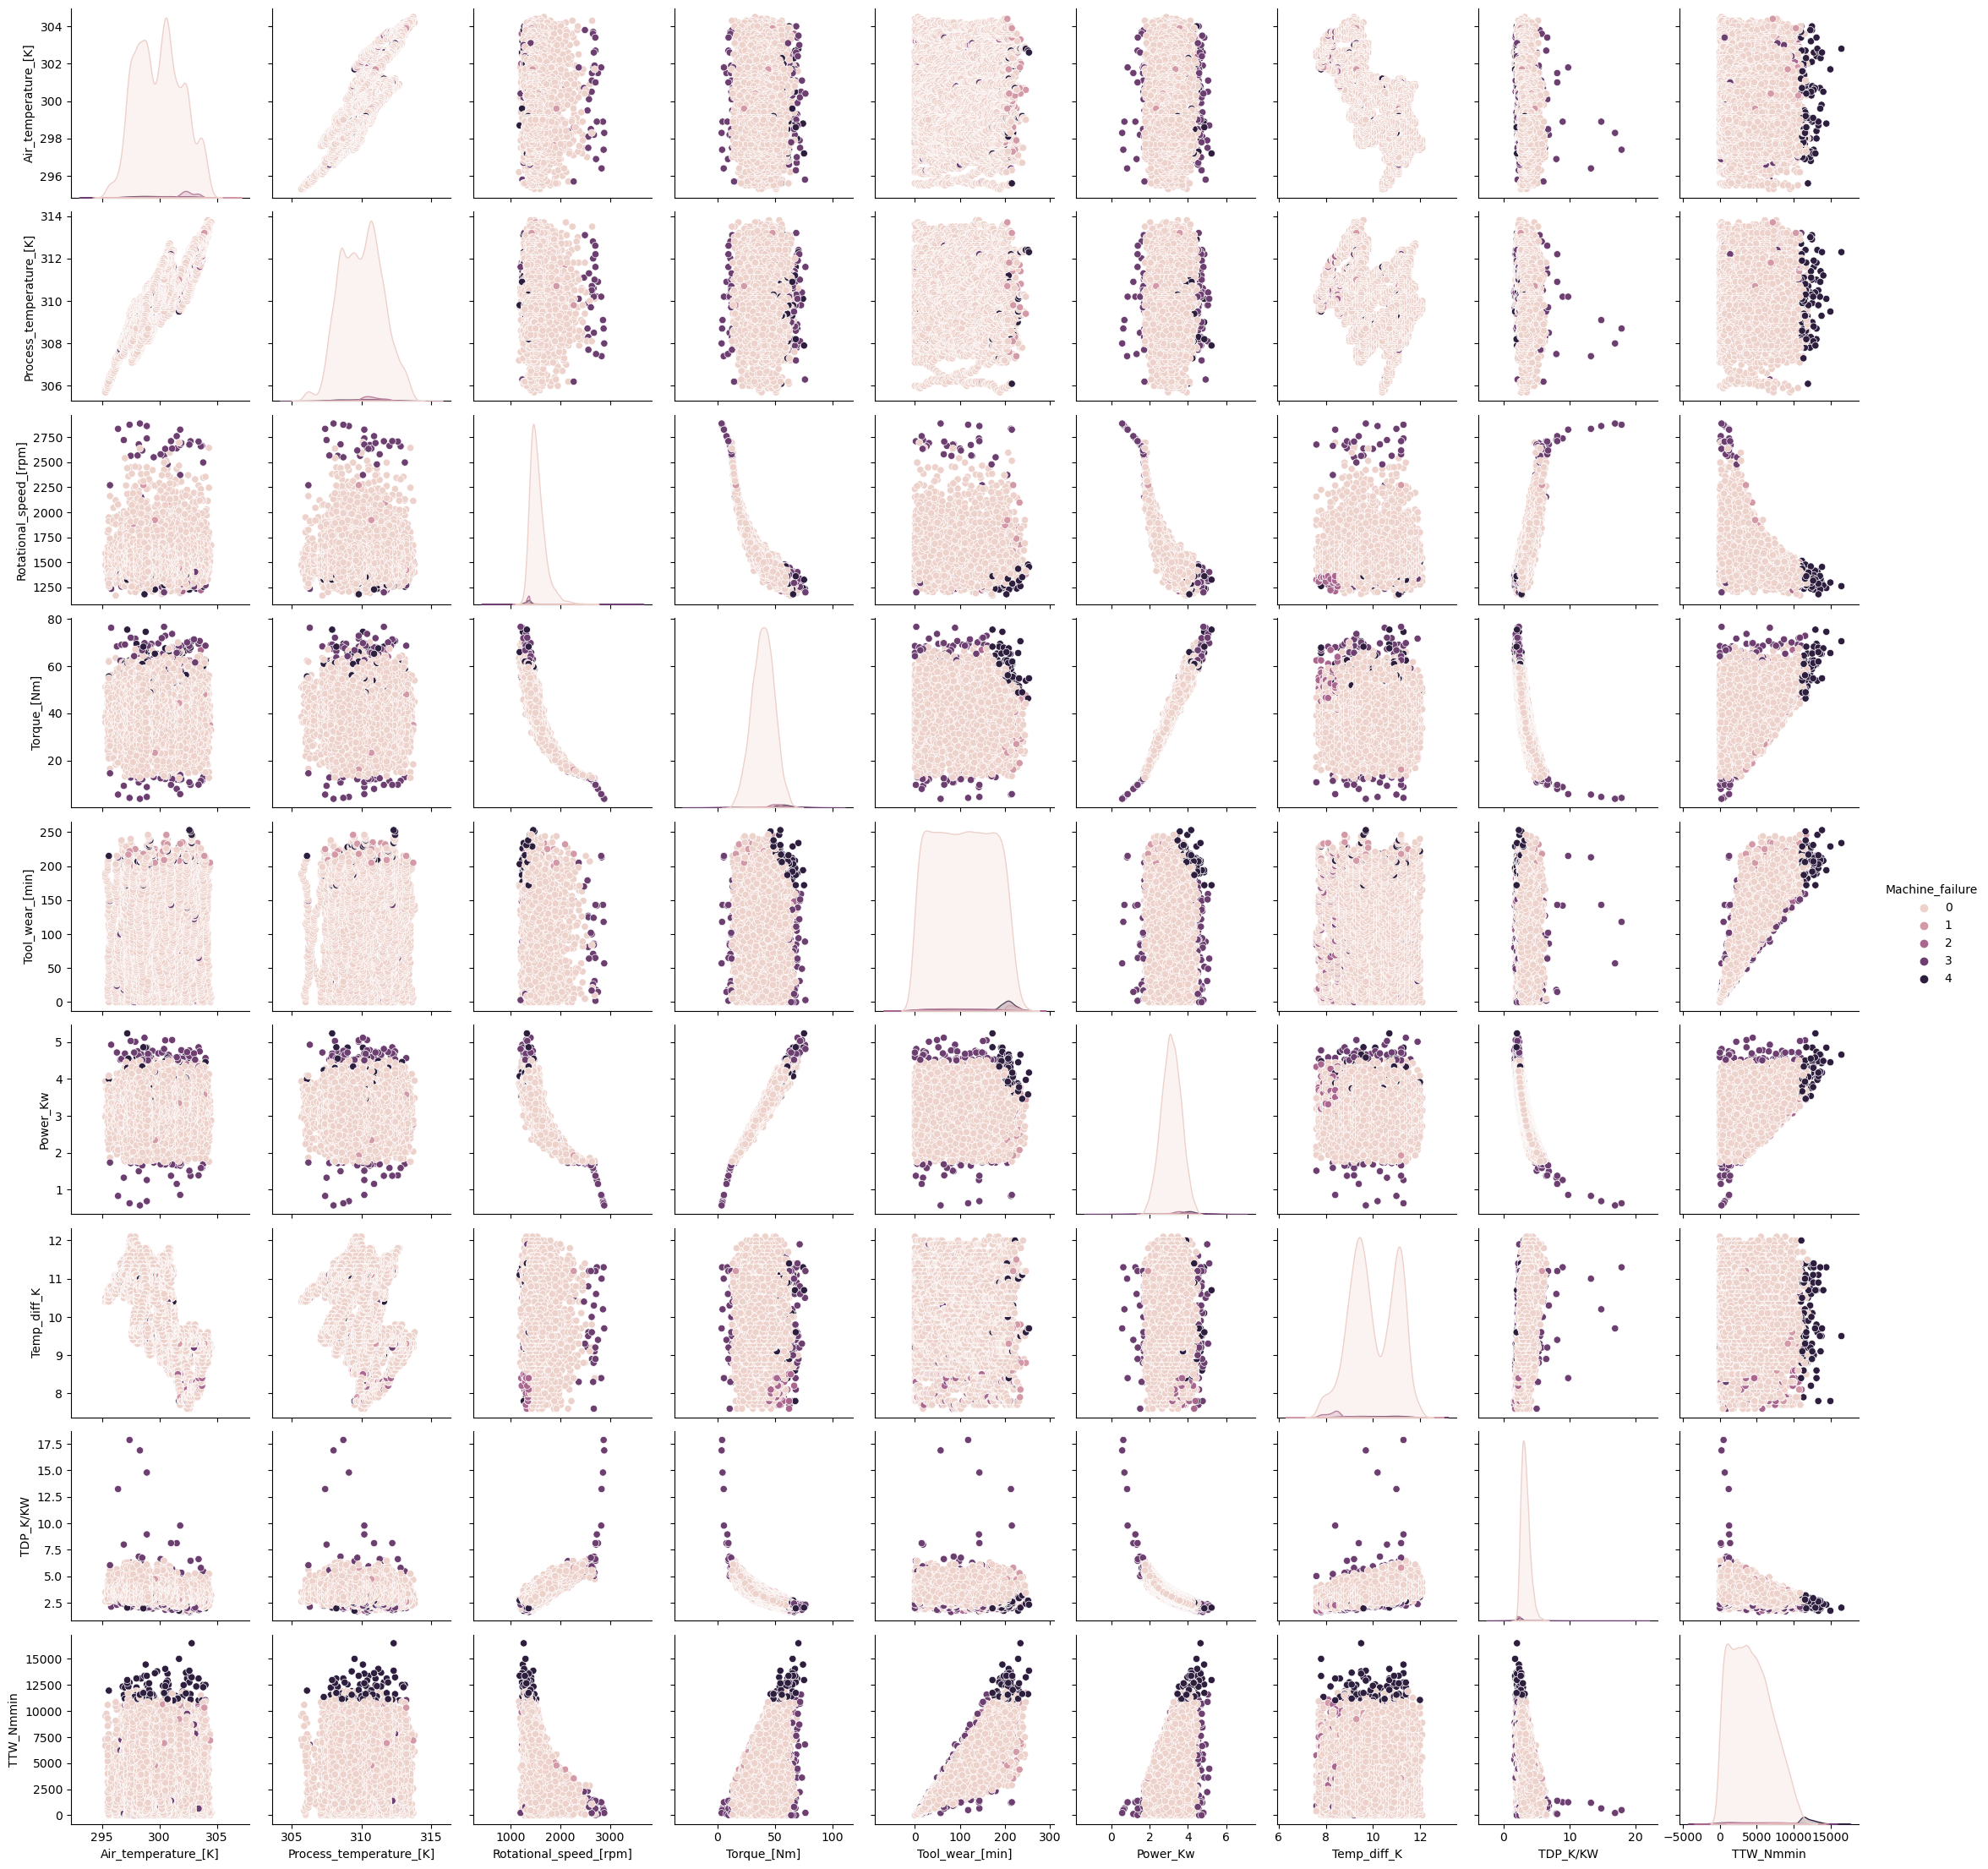

In [60]:
p=sns.pairplot(df, hue = 'Machine_failure')

In [61]:
df.Type.value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

In [15]:
df = pd.get_dummies(df, columns=['Type'])
df

Air_temperature_[K]  Process_temperature_[K]  Rotational_speed_[rpm]  \
0                   298.1                    308.6                    1551   
1                   298.2                    308.7                    1408   
2                   298.1                    308.5                    1498   
3                   298.2                    308.6                    1433   
4                   298.2                    308.7                    1408   
...                   ...                      ...                     ...   
9995                298.8                    308.4                    1604   
9996                298.9                    308.4                    1632   
9997                299.0                    308.6                    1645   
9998                299.0                    308.7                    1408   
9999                299.0                    308.7                    1500   

      Torque_[Nm]  Tool_wear_[min]  Machine_failure  Power_Kw  Temp_diff_K  \
0            42.8                0                0  3.477194         10.5   
1            46.3                3                0  3.414735         10.5   
2            49.4                5                0  3.876253         10.4   
3            39.5                7                0  2.964945         10.4   
4            40.0                9                0  2.950095         10.5   
...           ...              ...              ...       ...          ...   
9995         29.5               14                0  2.478562          9.6   
9996         31.8               17                0  2.718446          9.5   
9997         33.4               22                0  2.877967          9.6   
9998         48.5               25                0  3.576990          9.7   
9999         40.2               30                0  3.158571          9.7   

      TDP_K/KW  TTW_Nmmin  Type_H  Type_L  Type_M  
0     3.019676        0.0       0       0       1  
1     3.074909      138.9       0       1       0  
2     2.683003      247.0       0       1       0  
3     3.507653      276.5       0       1       0  
4     3.559207      360.0       0       1       0  
...        ...        ...     ...     ...     ...  
9995  3.873214      413.0       0       0       1  
9996  3.494644      540.6       1       0       0  
9997  3.335688      734.8       0       0       1  
9998  2.711777     1212.5       1       0       0  
9999  3.071009     1206.0       0       0       1  

[10000 rows x 13 columns]

## Feature Selection

C:\Users\chris\AppData\Local\Temp\ipykernel_40188\2358579485.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df.corr(), dtype=np.bool)


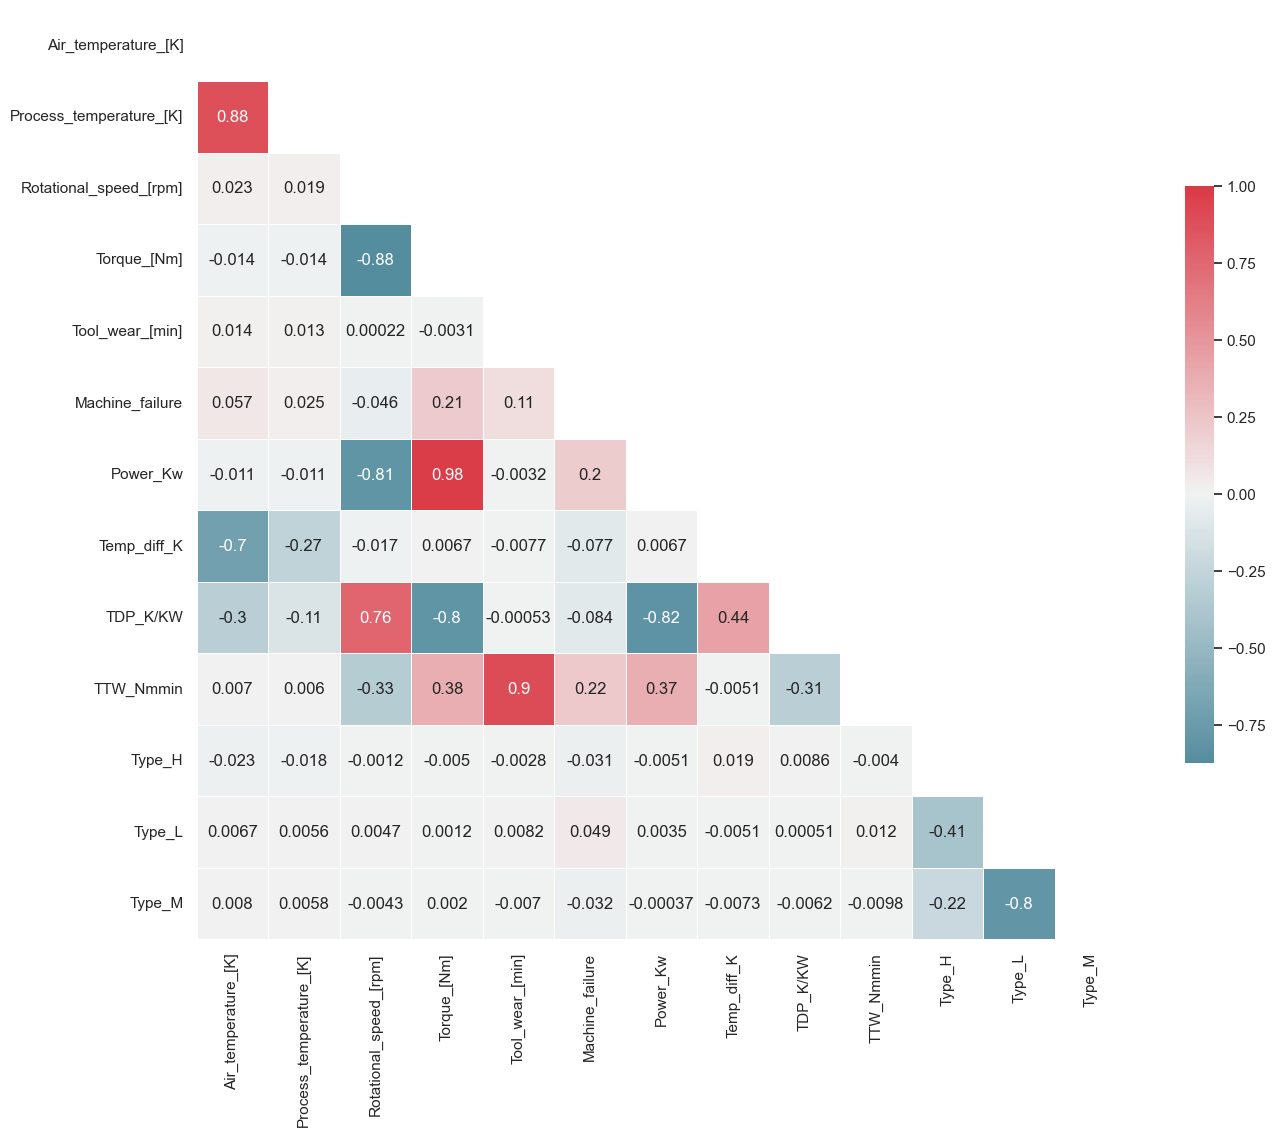

In [16]:
# Copied code from seaborn examples: another good way to show Correlation
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

In [17]:
df.corr()[['Machine_failure']].apply(np.abs).sort_values('Machine_failure', ascending=False)

Machine_failure
Machine_failure                 1.000000
TTW_Nmmin                       0.222638
Torque_[Nm]                     0.214632
Power_Kw                        0.204205
Tool_wear_[min]                 0.112998
TDP_K/KW                        0.083898
Temp_diff_K                     0.077003
Air_temperature_[K]             0.057239
Type_L                          0.048853
Rotational_speed_[rpm]          0.046262
Type_M                          0.032139
Type_H                          0.030657
Process_temperature_[K]         0.025211

## Create Model

In [18]:
predictor_columns = [c for c in df.columns if c != 'Machine_failure']
target_column = 'Machine_failure'

# Load the dataset as a pandas data frame
X = pd.DataFrame(df, columns = predictor_columns)
y = df[target_column]

In [22]:
X.head()

Air_temperature_[K]  Process_temperature_[K]  Rotational_speed_[rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque_[Nm]  Tool_wear_[min]  Power_Kw  Temp_diff_K  TDP_K/KW  TTW_Nmmin  \
0         42.8                0  3.477194         10.5  3.019676        0.0   
1         46.3                3  3.414735         10.5  3.074909      138.9   
2         49.4                5  3.876253         10.4  2.683003      247.0   
3         39.5                7  2.964945         10.4  3.507653      276.5   
4         40.0                9  2.950095         10.5  3.559207      360.0   

   Type_H  Type_L  Type_M  
0       0       0       1  
1       0       1       0  
2       0       1       0  
3       0       1       0  
4       0       1       0

In [23]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Machine_failure, dtype: int64

In [24]:
# SPLIT DATA INTO TRAINING AND TEST DATA 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=None, stratify=y, random_state=0)


# STANDARDISE TRAINING DATA  
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# FIT on training set only.
scaler.fit(X_train)


# APPLY TRANSFORM to both the training set AND the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



In [25]:
# HANDLE IMBALANCED TRAINING DATA

from imblearn.over_sampling import SMOTE 

model = SMOTE(random_state=42)
X_train, y_train = model.fit_resample(X_train, y_train)  # this gives the Resampled X and Y-training data

In [27]:
y_test.value_counts(normalize= True) 

0    0.9672
2    0.0104
4    0.0096
3    0.0084
1    0.0044
Name: Machine_failure, dtype: float64

In [26]:
y_train.value_counts(normalize= True) 

0    0.2
3    0.2
4    0.2
1    0.2
2    0.2
Name: Machine_failure, dtype: float64

In [28]:
import time
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','MCC score','time to train','time to predict','total time'])

## Random Forest

In [29]:
%%time

start = time.time()
model = RandomForestClassifier(n_estimators = 600,n_jobs=-1,random_state=0,bootstrap=True,).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: total: 31.5 s
Wall time: 3.19 s


In [30]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)


print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 98.04%
Recall: 98.04%
Precision: 98.95%
F1-Score: 98.48%
MCC: 74.18%
time to train: 3.07 s
time to predict: 0.11 s
total: 3.19 s


C:\Users\chris\anaconda3\envs\IOD\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


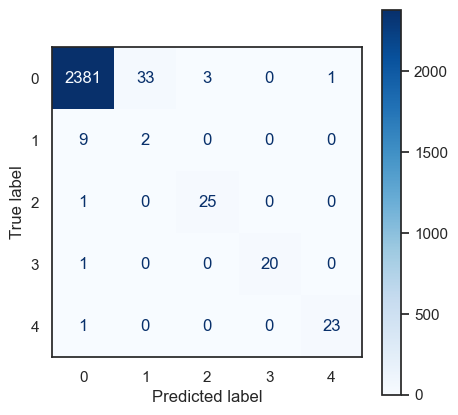

In [31]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [32]:
#GRIDSEARCH ON RANDOM FOREST

rf_params = {
    'n_estimators': [100,300,600,800]
}

rf_gs = GridSearchCV(RandomForestClassifier(random_state=1, bootstrap=True), rf_params, cv=3, verbose=3, 
                     n_jobs=-1)
rf_gs.fit(X_train, y_train)

# USE TQDM to check progress of processing
from tqdm import tqdm
for i in tqdm (range(2)):     # tqdm tracks progress of processing, useful in running loops
    best_svc = rf_gs.best_estimator_
    print(rf_gs.best_params_)
    print(rf_gs.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


100%|██████████| 2/2 [00:00<?, ?it/s]

{'n_estimators': 300}
0.9963320311144647
{'n_estimators': 300}
0.9963320311144647


## Random Forest after Gridsearch

In [33]:
%%time

start = time.time()
model = RandomForestClassifier(n_estimators = 300,n_jobs=-1,random_state=0,bootstrap=True,).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: total: 19.9 s
Wall time: 1.76 s


In [34]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)


print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 98.04%
Recall: 98.04%
Precision: 98.95%
F1-Score: 98.48%
MCC: 74.18%
time to train: 1.70 s
time to predict: 0.06 s
total: 1.76 s


C:\Users\chris\anaconda3\envs\IOD\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


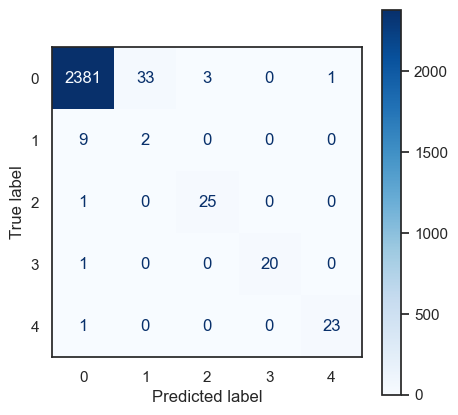

In [35]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [36]:
%%time

from xgboost import XGBClassifier
start = time.time()
model = XGBClassifier(learning_rate=0.1,n_estimators=600,max_depth =5, random_state=0, n_jobs=-1)
model.fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: total: 3min 4s
Wall time: 12.2 s


In [37]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)


print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['XGradient Boost'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 98.60%
Recall: 98.60%
Precision: 99.10%
F1-Score: 98.84%
MCC: 80.31%
time to train: 12.18 s
time to predict: 0.01 s
total: 12.18 s


C:\Users\chris\anaconda3\envs\IOD\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


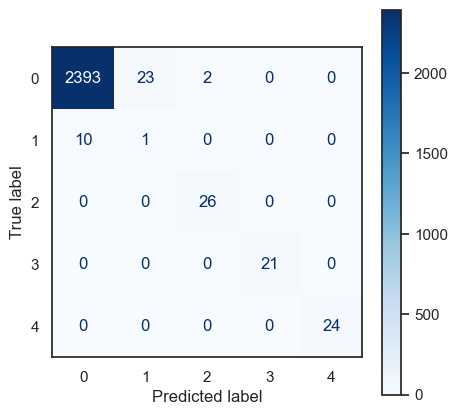

In [38]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [41]:
%%time
from sklearn.neural_network import MLPClassifier
start = time.time()
model = MLPClassifier(hidden_layer_sizes = (100,100,4), 
                      activation='relu', 
                      solver='adam',
                      max_iter=1000,
                      random_state=0,
                      batch_size=2000,
                      verbose=0).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: total: 5min 34s
Wall time: 1min 5s


In [42]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))

print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Neural Network MLP'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 94.56%
Recall: 94.56%
Precision: 97.51%
F1-Score: 95.88%
MCC: 50.26%
time to train: 65.49 s
time to predict: 0.00 s
total: 65.49 s


C:\Users\chris\anaconda3\envs\IOD\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


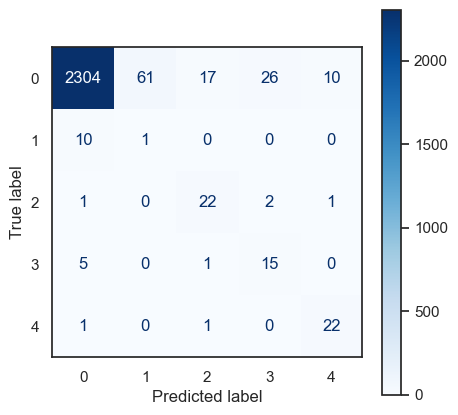

In [43]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [63]:
X_train.shape[1]

12

In [88]:
# # Set up the model architecture
# model = Sequential()
# # Add the first hidden layer
# model.add(Dense(100, activation = 'relu', input_shape = (X_train.shape[1], )))
# # Add the second hidden layer
# model.add(Dense(100, activation = 'relu'))

# # Add the output layer
# model.add(Dense(1, activation = 'softmax'))

# # Compile the model
# model.compile(
#     optimizer = 'sgd',
#     loss = 'categorical_crossentropy',
#     metrics = ['accuracy'])


In [91]:
%%time
# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_split = 0.25,
    batch_size = 200,
    epochs = 100,
    verbose = 1)

Epoch 1/100
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.9641 - val_loss: nan - val_accuracy: 0.9685
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.9641 - val_loss: nan - val_accuracy: 0.9685
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.9641 - val_loss: nan - val_accuracy: 0.9685
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.9641 - val_loss: nan - val_accuracy: 0.9685
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.9641 - val_loss: nan - val_accuracy: 0.9685
Epoch 6/100
29/29 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.9641 - val_loss: nan - val_accuracy: 0.9685
Epoch 7/100
29/29 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.9641 - val_loss: nan - val_accuracy: 0.9685
Epoch 8/100
29/29 [==============================] - 0s

In [64]:
# print(X_test)

[[0.40217391 0.5308642  0.1852286  ... 0.         1.         0.        ]
 [0.70652174 0.61728395 0.54161782 ... 0.         1.         0.        ]
 [0.93478261 0.90123457 0.22450176 ... 0.         1.         0.        ]
 ...
 [0.56521739 0.49382716 0.12661196 ... 0.         1.         0.        ]
 [0.22826087 0.34567901 0.18112544 ... 0.         1.         0.        ]
 [0.25       0.33333333 0.2045721  ... 0.         1.         0.        ]]


In [98]:
# predictions = model.predict(X_test)

79/79 [==============================] - 0s 754us/step


In [100]:
# print(predictions)

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


In [44]:
%%time
from sklearn.tree import DecisionTreeClassifier
start = time.time()
model = DecisionTreeClassifier().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: total: 203 ms
Wall time: 251 ms


In [45]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)


print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Decision Tree'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 97.96%
Recall: 97.96%
Precision: 98.86%
F1-Score: 98.40%
MCC: 73.08%
time to train: 0.25 s
time to predict: 0.00 s
total: 0.25 s


C:\Users\chris\anaconda3\envs\IOD\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


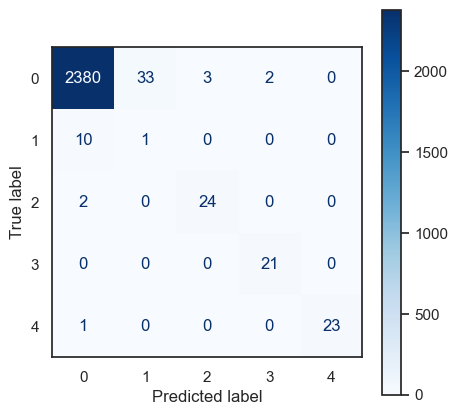

In [46]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [47]:
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'MCC score': '{:.2%}',
                                                                     'time to train':'{:.1f}',
                                                                     'time to predict':'{:.1f}',
                                                                     'total time':'{:.1f}',
                                                                     })